In [257]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer


In [30]:
import mne
from mne.datasets.sleep_physionet.age import fetch_data

VAMOS USAR 4 pessoas para treinar o  modelo, 2 para teste

In [31]:
p1, p2, p3, p4, p5, p6 = 0, 1, 2 , 3, 4, 5

In [35]:
train1.set_annotations(annot_train1, emit_warning=False)

Measurement date,"April 24, 1989 16:13:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,"2 EEG, 1 EOG, 1 Respiration monitoring channel, 1 EMG, 1 Temperature, 1 Stimulus"
Bad channels,None
EOG channels,horizontal
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.00 Hz
Lowpass,50.00 Hz


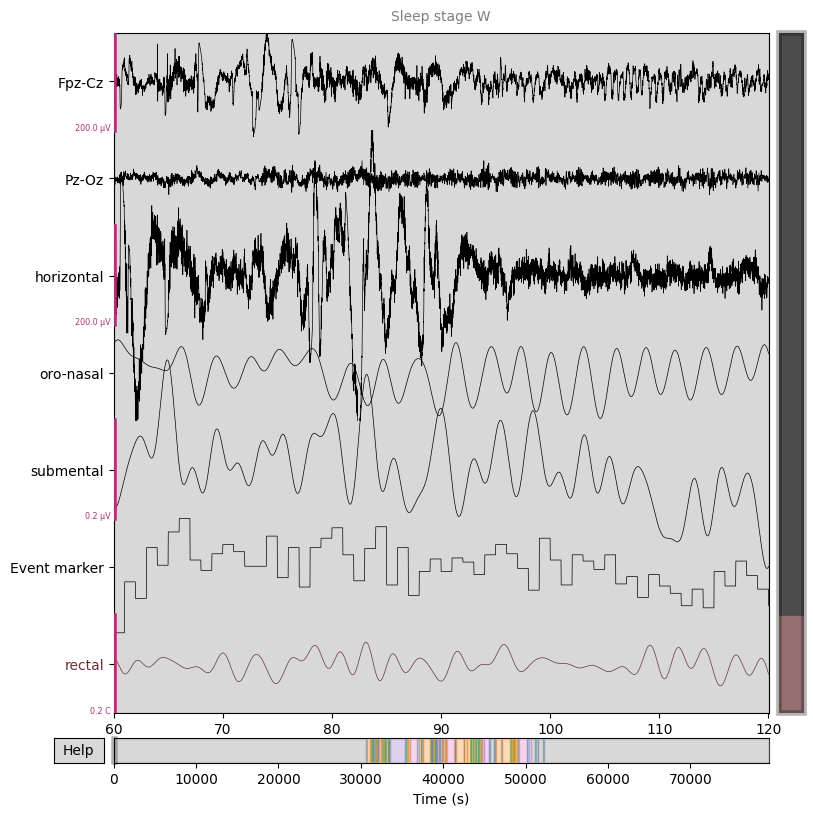

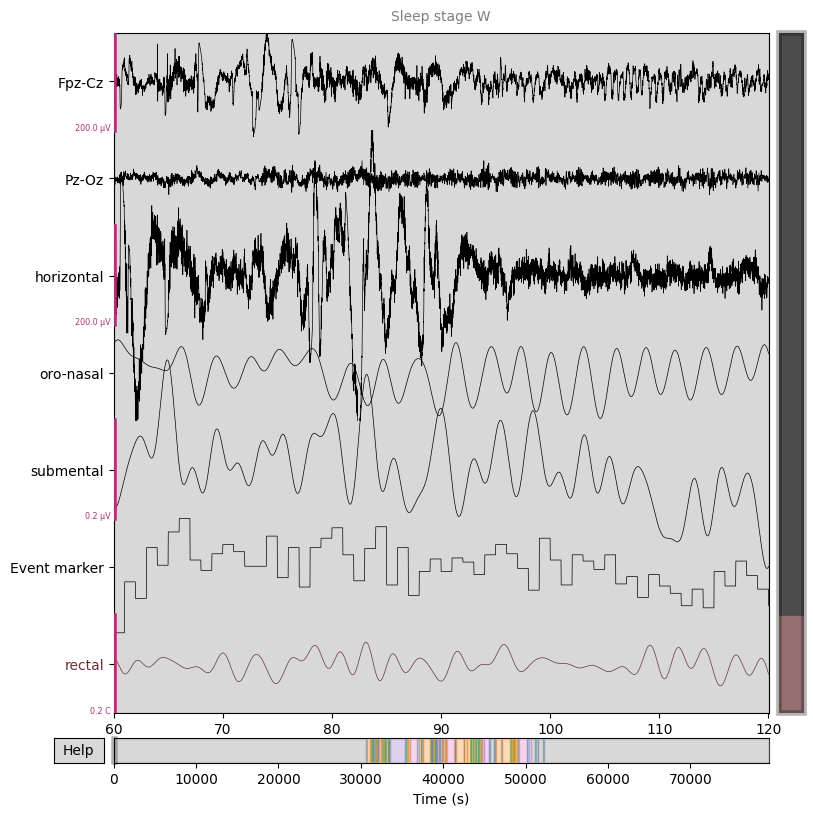

In [36]:
train1.plot(
    start=60,
    duration=60,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1),
)

epochs de 30 segundos

In [37]:
events_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 5,
    "Sleep stage R": 6,
}


In [38]:
annot_train1.crop(annot_train1[1]["onset"] - 30 * 60, annot_train1[-2]["onset"] + 30 * 60)
train1.set_annotations(annot_train1, emit_warning=False)
events_train1, _ = mne.events_from_annotations(
    train1, event_id=events_id, chunk_duration=30.0
)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


In [39]:
colour_dict = {
    'C1': '#1f77b4',  # Blue
    'C2': '#ff7f0e',  # Orange
    'C3': '#2ca02c',  # Green
    'C4': '#d62728',  # Red
    'C5': '#9467bd', 
    'C6': '#ffff00'
}


/Users/Bia/Library/Python/3.9/lib/python/site-packages/mne/viz/misc.py:1400: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if key in unique_events:  # key was a valid event integer
/var/folders/l_/hg8v1x2n6sn481rmk8n90ftw0000gn/T/ipykernel_62277/3514364914.py:1: RuntimeWarning: Event ID C1 is in the color dict but is not present in events or event_id.
  fig = mne.viz.plot_events(
/var/folders/l_/hg8v1x2n6sn481rmk8n90ftw0000gn/T/ipykernel_62277/3514364914.py:1: RuntimeWarning: Event ID C2 is in the color dict but is not present in events or event_id.
  fig = mne.viz.plot_events(
/var/folders/l_/hg8v1x2n6sn481rmk8n90ftw0000gn/T/ipykernel_62277/3514364914.py:1: RuntimeWarning: Event ID C3 is in the color dict but is not present in events or event_id.
  fig = mne.viz.plot_events(
/var/folders/l_/hg8v1x2n6sn481rmk8n90ftw0000gn/T/ipykernel_62277/3514364914.py:1: RuntimeWarning: Event ID C4 is in the color dict 

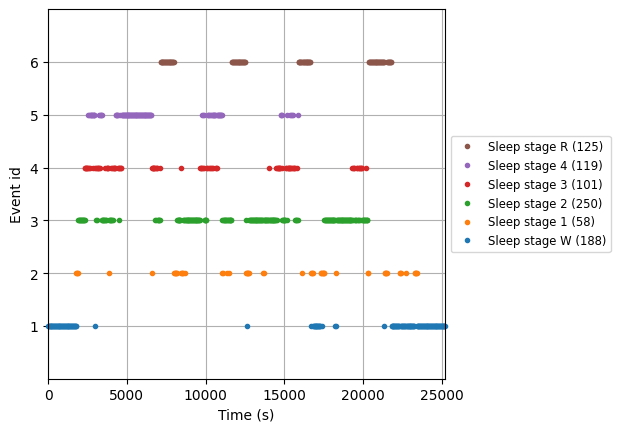

In [40]:
fig = mne.viz.plot_events(
    events_train1,
    event_id=events_id,
    sfreq=train1.info["sfreq"],
    color = colour_dict,
    first_samp=events_train1[0, 0],
)

In [41]:
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [42]:
tmax = 30.0 - 1.0 / train1.info["sfreq"]  # tmax in included

epochs_train1 = mne.Epochs(
    raw=train1,
    events=events_train1,
    event_id=events_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)


Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated


In [43]:
epochs_train1

Number of events,841
Events,Sleep stage 1: 58Sleep stage 2: 250Sleep stage 3: 101Sleep stage 4: 119Sleep stage R: 125Sleep stage W: 188
Time range,0.000 – 29.990 s
Baseline,off


In [44]:
a =   [1, 2, 3]
print(len(a))

3


In [45]:
x = range(0, len(a)-1)
print(x)

range(0, 2)


In [46]:
ub = [None] * len(a)
for i in range(0, len(a)):
    ub[i] = i
print(ub)

[0, 1, 2]


In [47]:
subject = [pf1, pf2, pf3, pf4, pf5,pf6 ]

In [48]:
subject[1][0]

'/Users/Bia/mne_data/physionet-sleep-data/SC4011E0-PSG.edf'

In [49]:
for i in range(0, 1): 
    print(i)

0


isto sou eu a tentar fazer uma função que faça tudo

**_Direito para tudo_** 

In [224]:
subjects = [0, 1, 2 , 3, 4, 5]
sub = [p1, p2, p3,p4, p5, p6]
sub =  fetch_data(subjects = subjects, recording=[1])



Using default location ~/mne_data for PHYSIONET_SLEEP...


Análise da qualidade dos dados, em raw


In [238]:
def signal_stage(subjects, sub):
     # guarda todos os sinais originais
    signal_EEG = [None] * len(subjects)
    signal_EOG = [None] * len(subjects) # estes são os sinais que pretendemos, para cada utilizador
    annot = [None] * len(subjects) #anotções dos sinais

    events_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 5,
    "Sleep stage R": 6}


    for i in range(0, len(subjects)):
        signal =  mne.io.read_raw_edf(
            sub[i][0],
            stim_channel="Event marker",
            infer_types=True,
            preload=True,
            verbose="error",  # ignore issues with stored filter settings
        )
        a = signal.copy()
        b = signal.copy()
        signal_EEG[i] = a.pick(["eeg"]).load_data()
        signal_EOG[i] = b.pick(["eog"]).load_data()

        signal_EEG[i].set_eeg_reference("average", projection=True)
        annot[i] =  mne.read_annotations(sub[i][1])
        signal_EEG[i].set_annotations(annot[i], emit_warning=False)
        signal_EOG[i].set_annotations(annot[i], emit_warning=False)
    return(signal_EEG,signal_EOG , annot)

In [240]:
[signal_EEG, signal_EOG , annot] = signal_stage(subjects, sub)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projecti

In [241]:
signal_EEG[1].info

Measurement date,"March 29, 1989 16:49:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,2 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.00 Hz
Lowpass,50.00 Hz


In [244]:
signal_EOG[1].info

Measurement date,"March 29, 1989 16:49:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,1 EOG
Bad channels,None
EOG channels,horizontal
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.00 Hz
Lowpass,50.00 Hz


In [185]:
def signal_representation (subjects, signal, annot):
    events_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 5,
    "Sleep stage R": 6}

    event_signal = [None] * len(subjects) 
    for i in range(0, len(subjects)):
        signal[i].plot(
                start=60,
                duration=60,
                scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1))

        # janelas de 30 segundos e observar localização de  eventos temporalmente
        annot[i].crop(annot[i][1]["onset"] - 30 * 60, annot[i][-2]["onset"] + 30 * 60)
        signal[i].set_annotations(annot[i], emit_warning=False)

        event_signal[i], _ = mne.events_from_annotations(
        signal[i], event_id=events_id, chunk_duration=30.0)
        
        fig = mne.viz.plot_events(
            event_signal[i],
            event_id=events_id,
            sfreq=signal[i].info["sfreq"],
            first_samp= event_signal[i][0, 0], on_missing="ignore")
       
    return(event_signal)

        
        
    

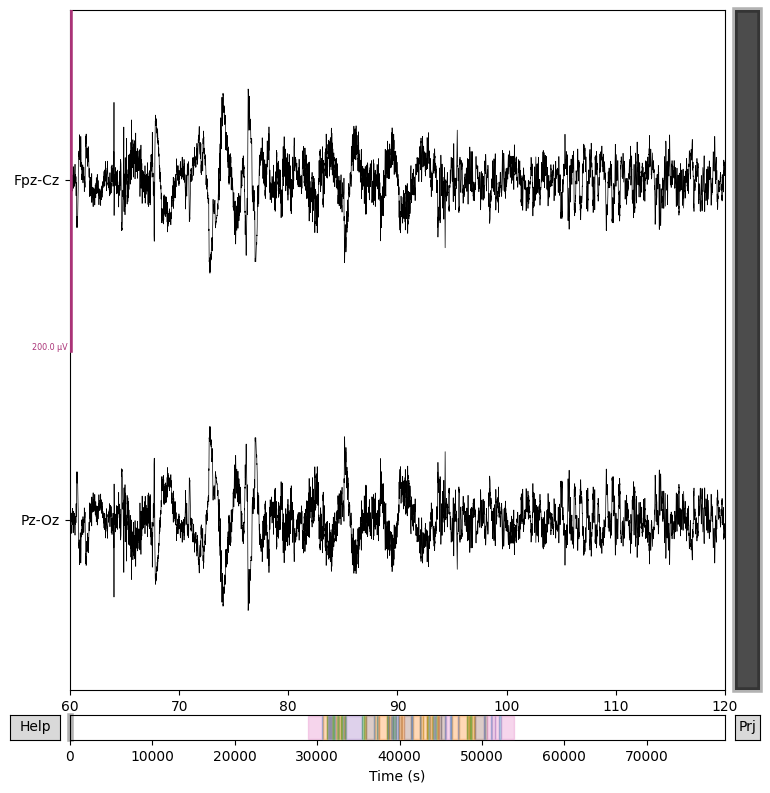

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


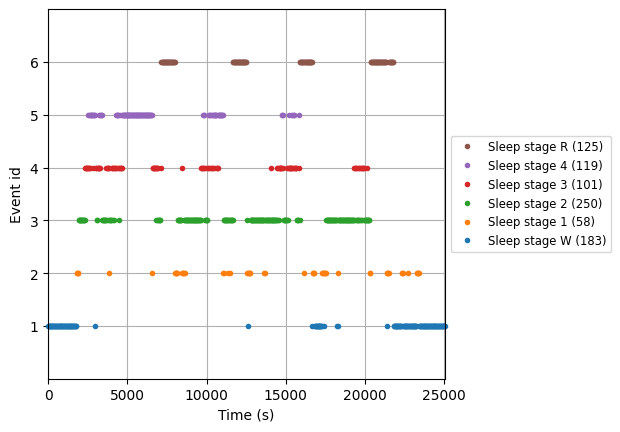

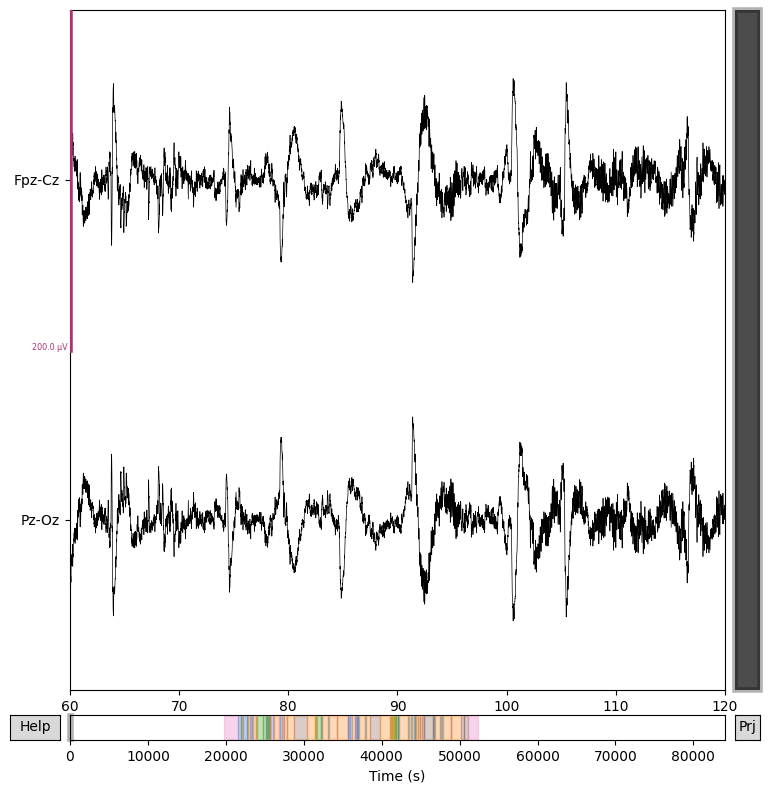

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


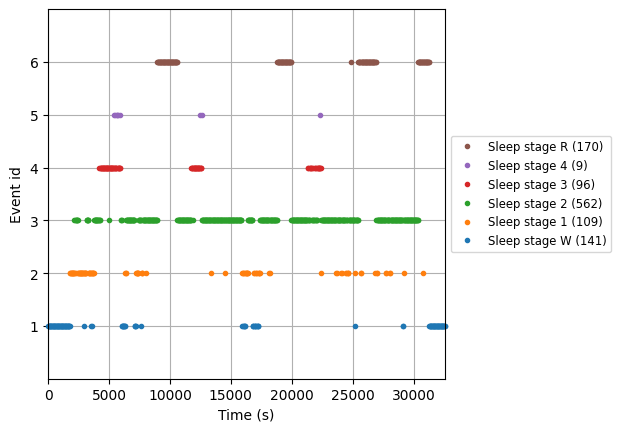

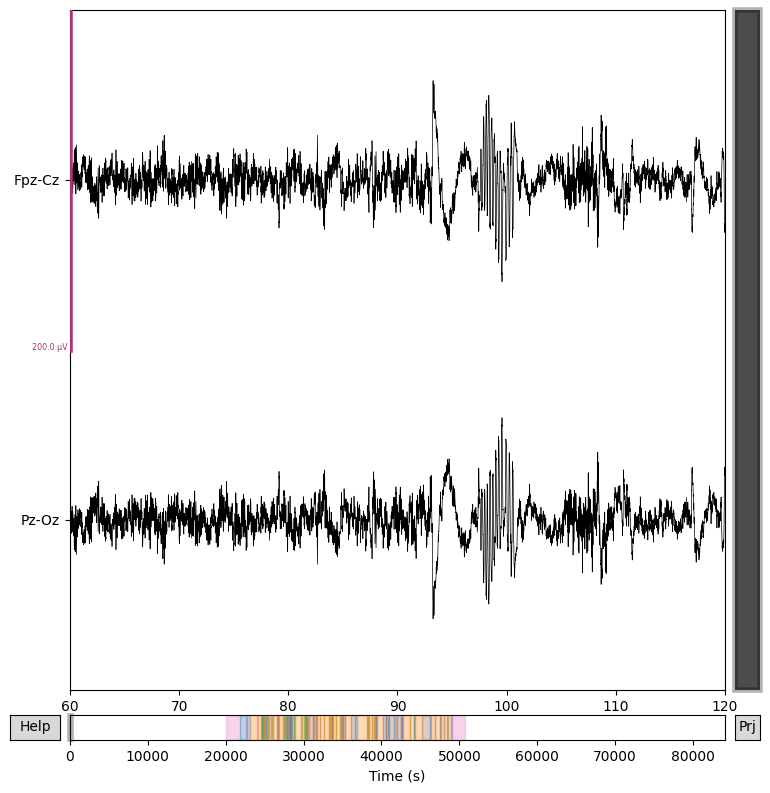

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


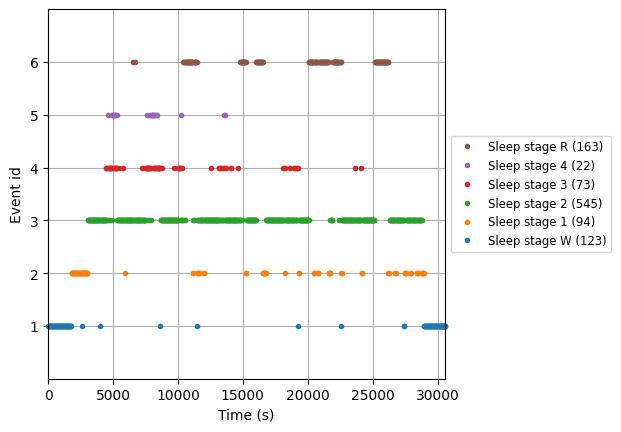

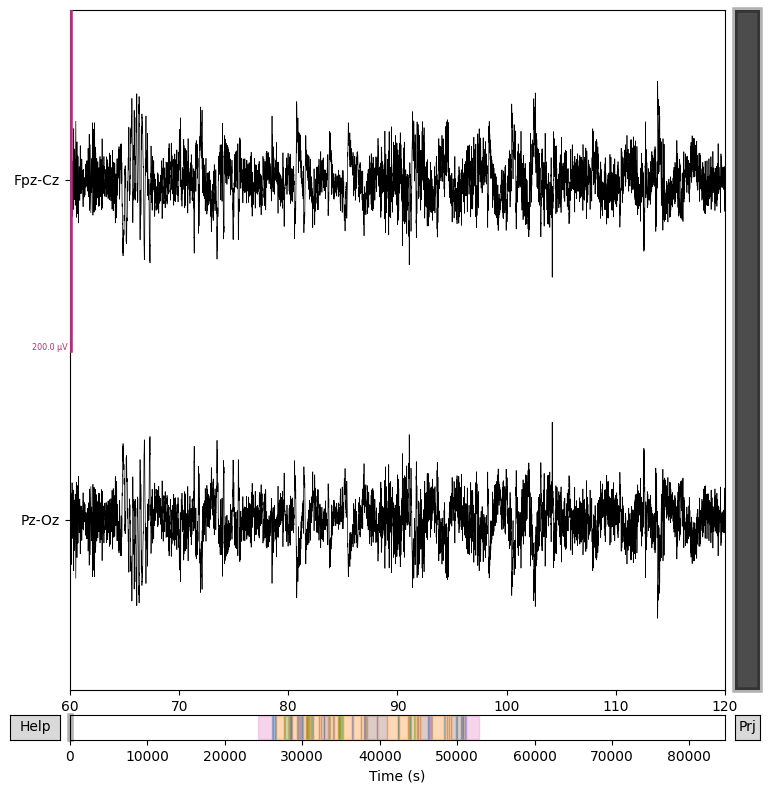

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


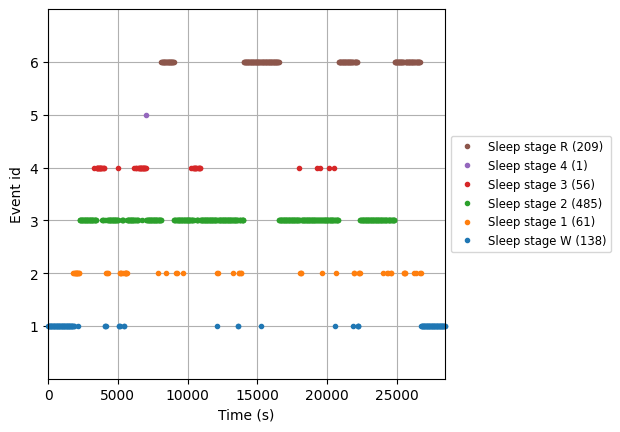

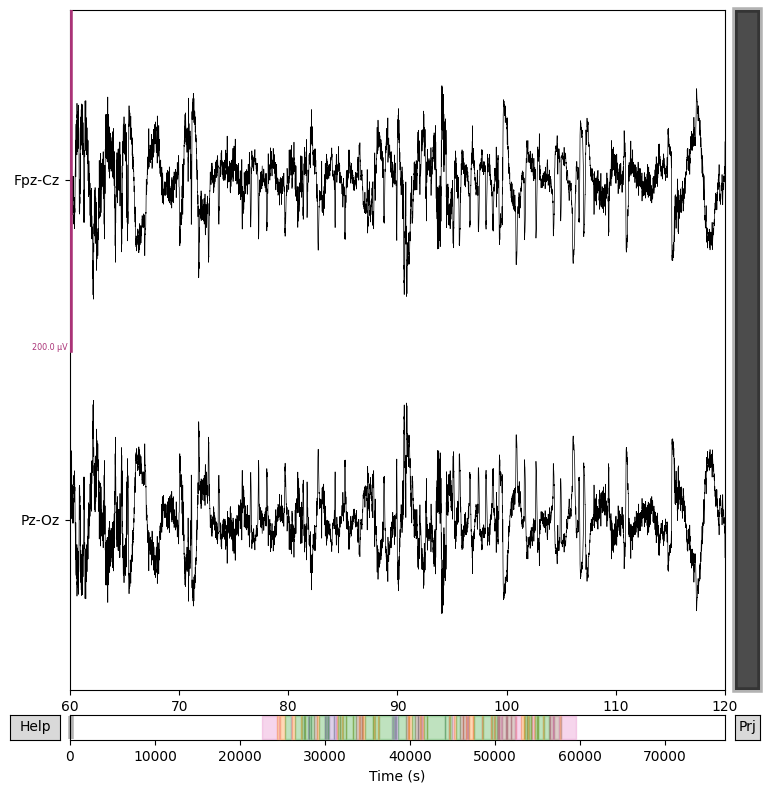

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']


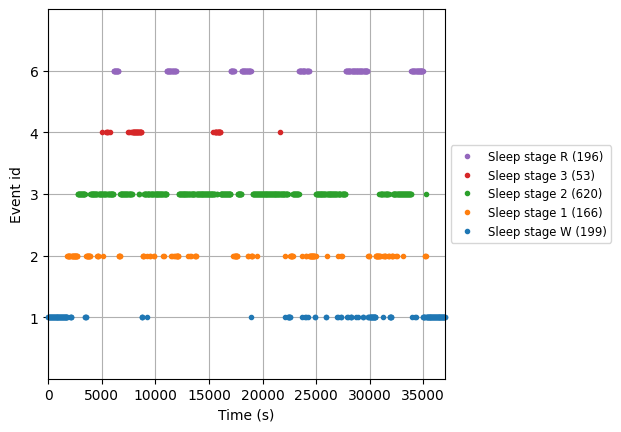

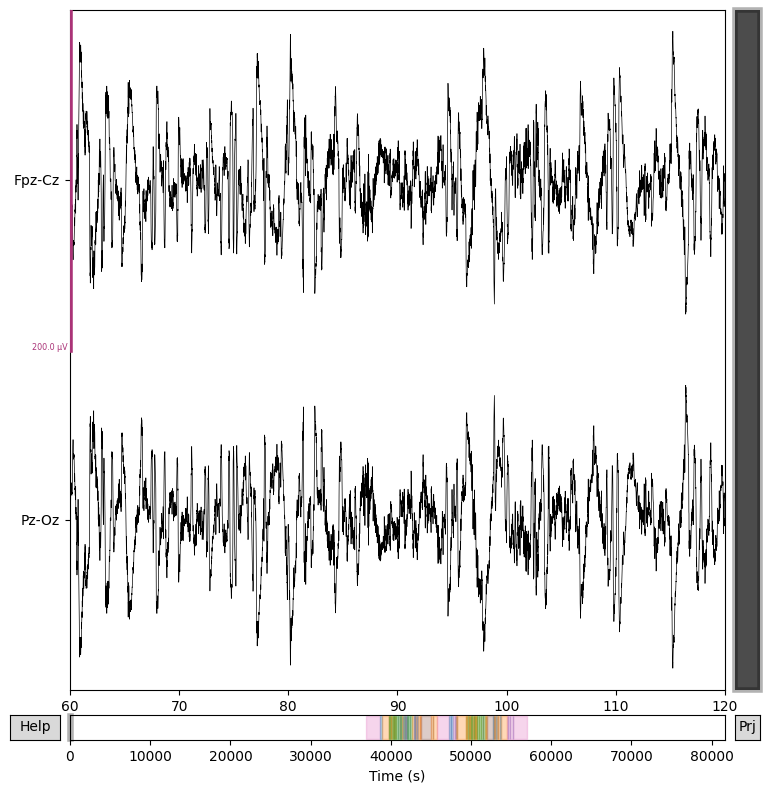

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


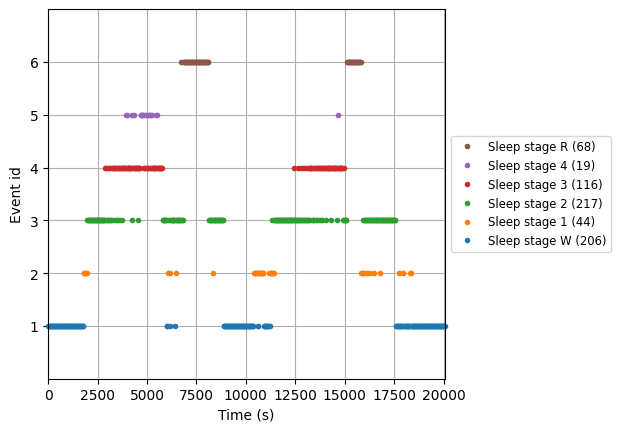

In [246]:
events_EEG = signal_representation(subjects,signal_EEG, annot)



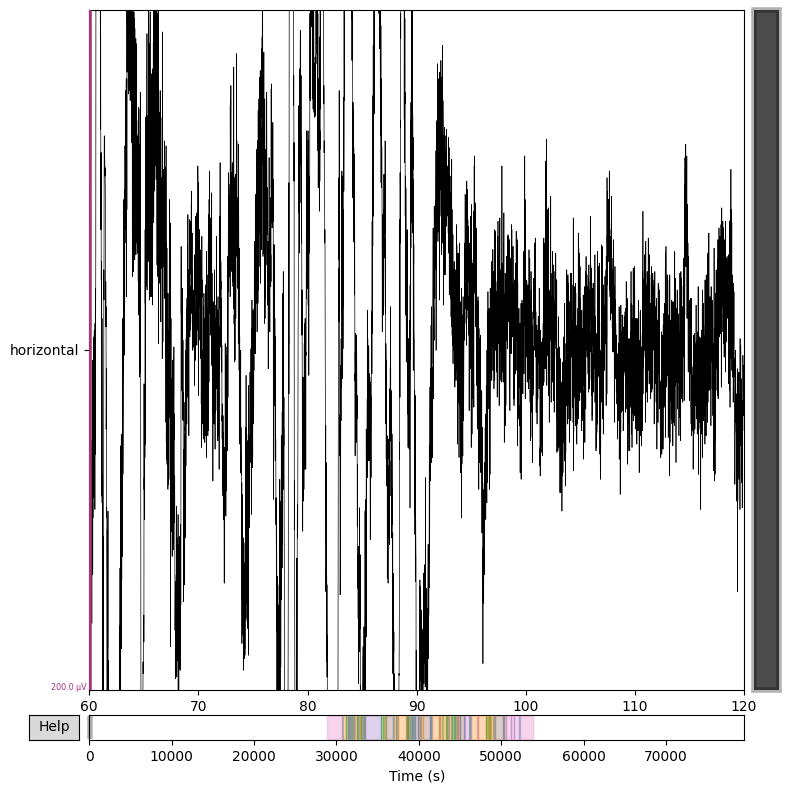

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


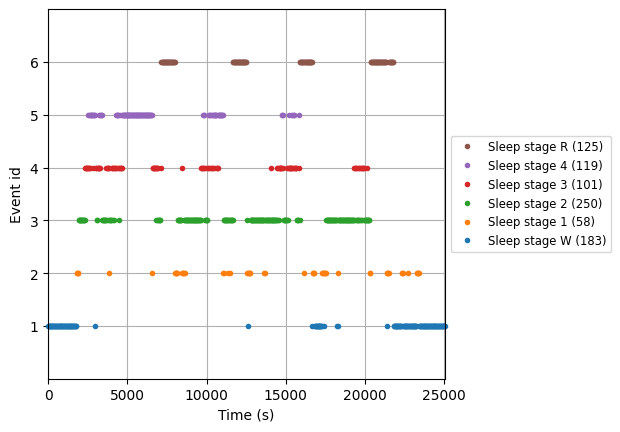

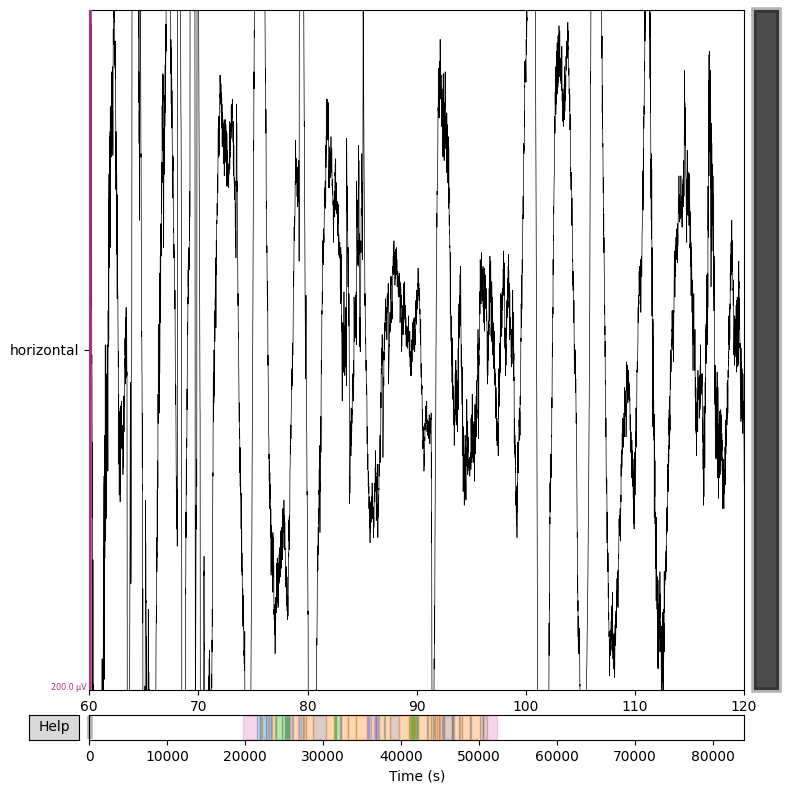

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


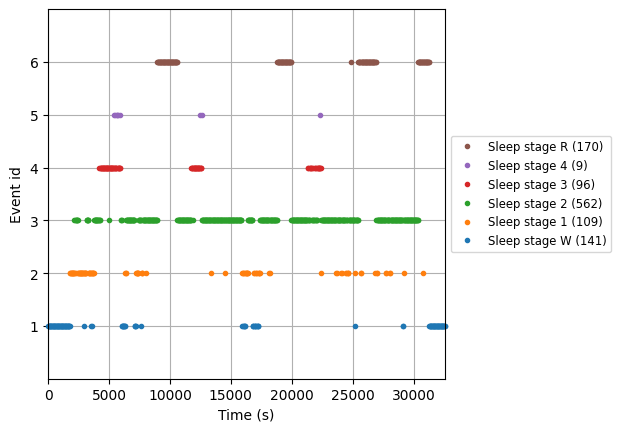

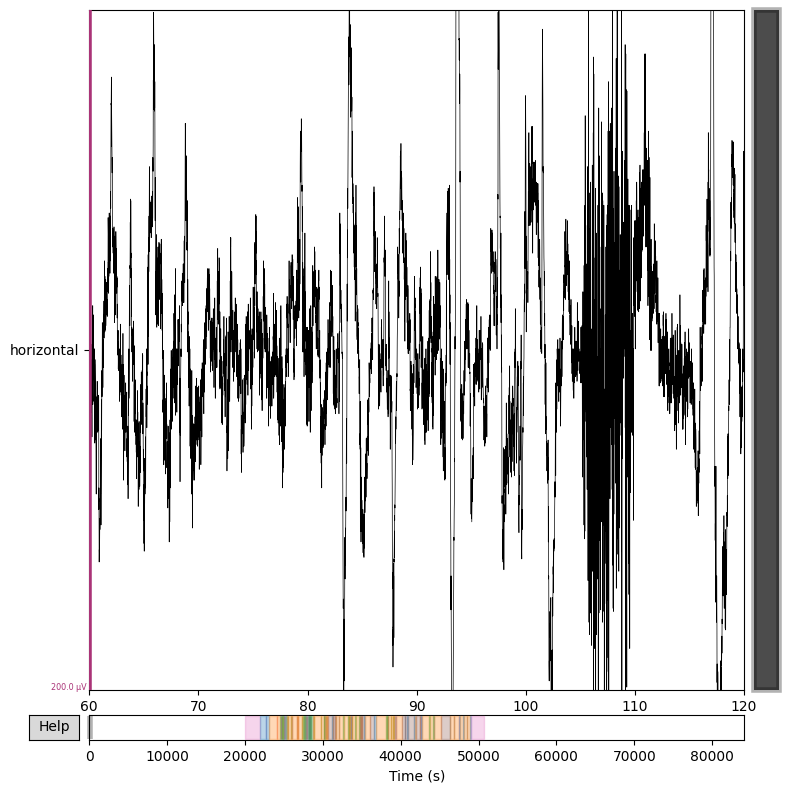

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


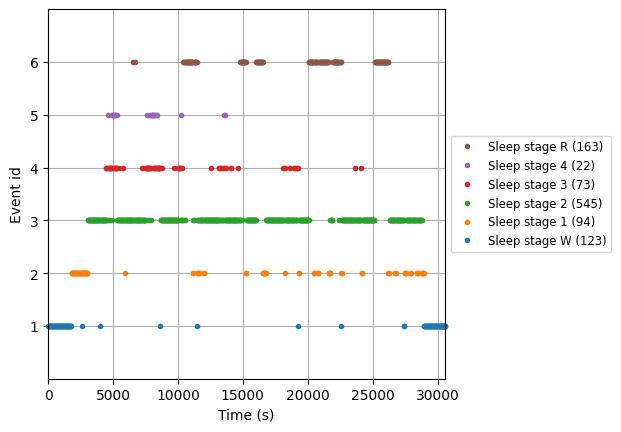

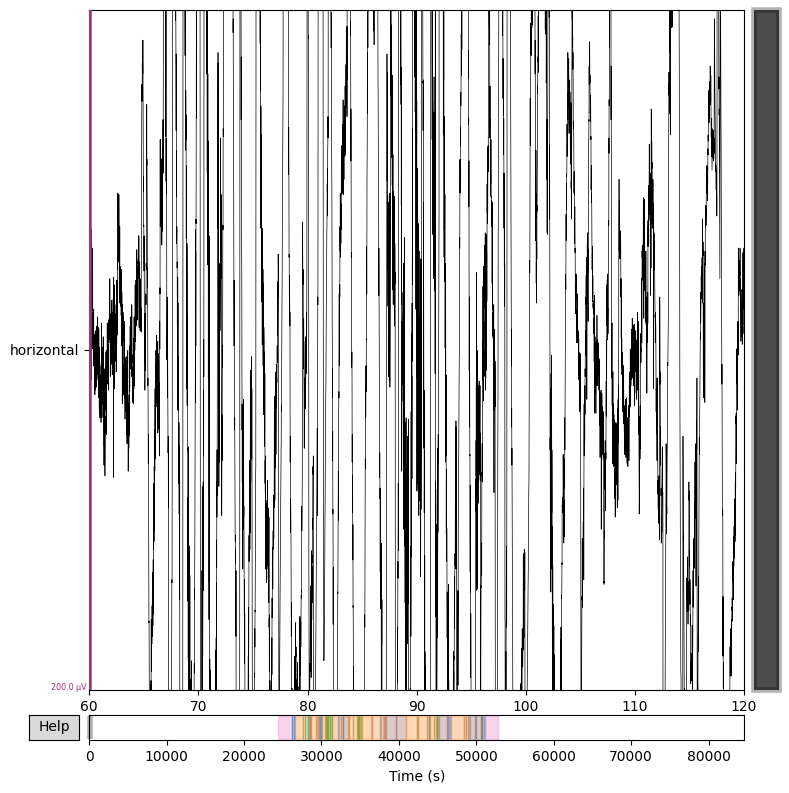

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


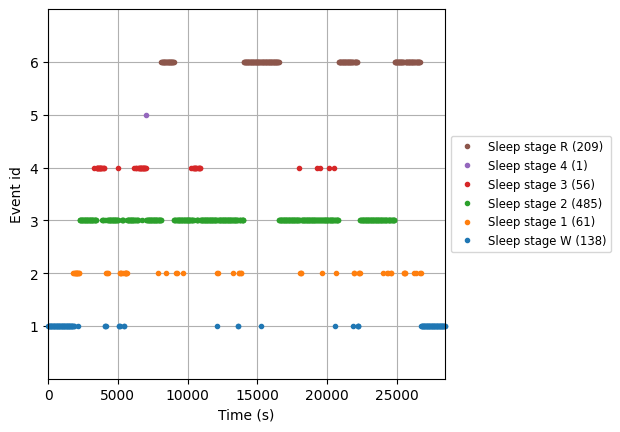

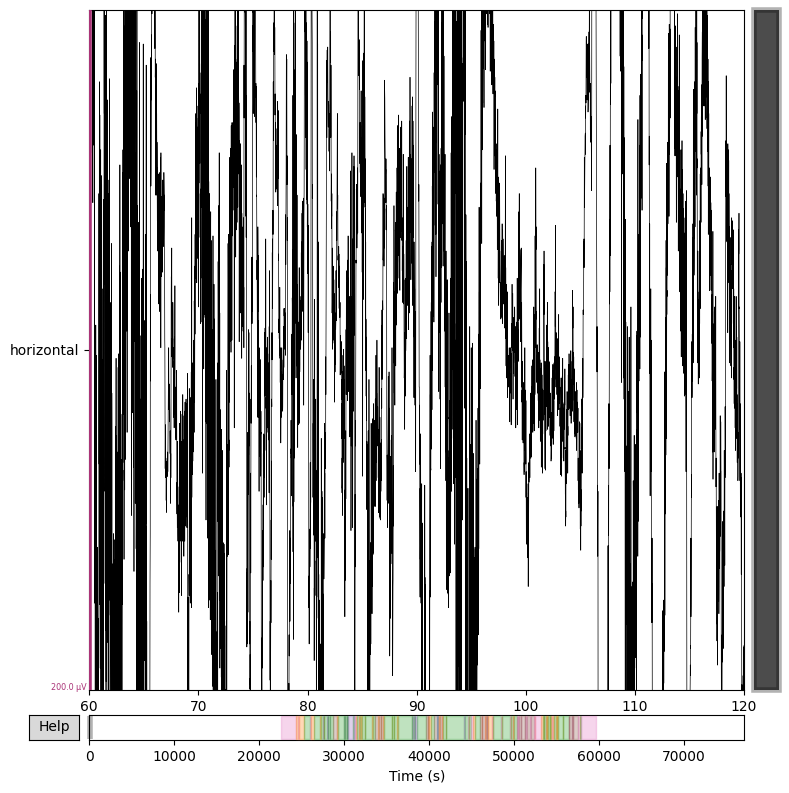

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']


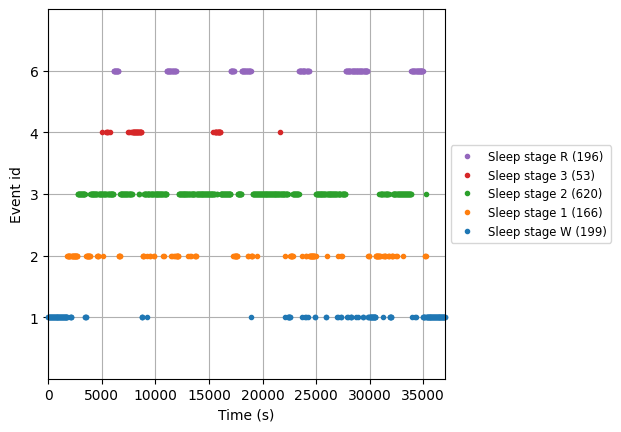

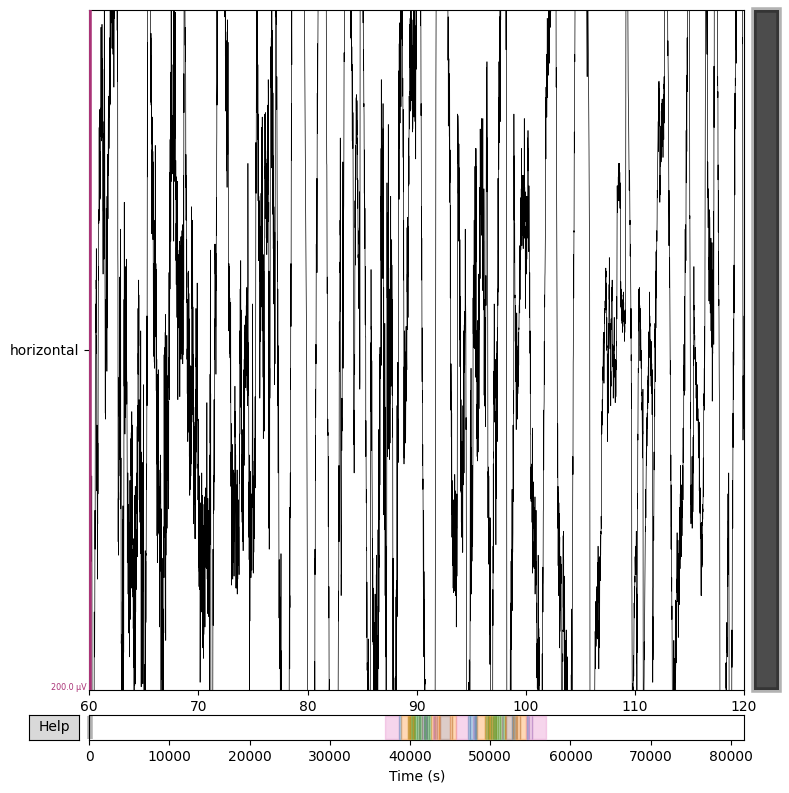

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


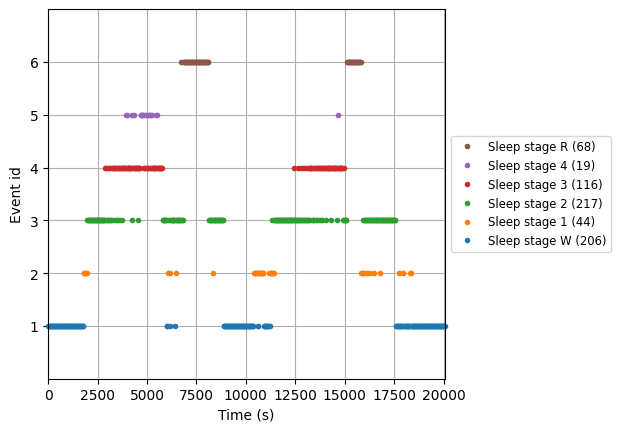

In [247]:
events_EOG = signal_representation(subjects,signal_EOG, annot)

In [176]:
def signal_epochs(subjects,signal,event_signal ):
    
    events_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 5,
    "Sleep stage R": 6}

    epochs = [None] * len(subjects)

    for i in range(0, len(subjects)):
        tmax = 30.0 - 1.0 / signal[i].info["sfreq"] 

        epochs[i] = mne.Epochs(
            raw=signal[i],
            events=event_signal[i],
            event_id=events_id,
            tmin=0.0,
            tmax=tmax,
            baseline=None, 
            on_missing = "ignore"
        )
    return(epochs)


In [243]:
epoch_EEG = signal_epochs(subjects,signal_EEG,events_EEG )
epoch_EOG = signal_epochs(subjects,signal_EOG,events_EOG )

Not setting metadata
841 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
1103 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
1025 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
952 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
1235 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
672 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
836 matching events found
No baseline co

**Exemplo: visualizar EEG com eventos marcado, 3 epochs**

Using data from preloaded Raw for 3 events and 3000 original time points ...


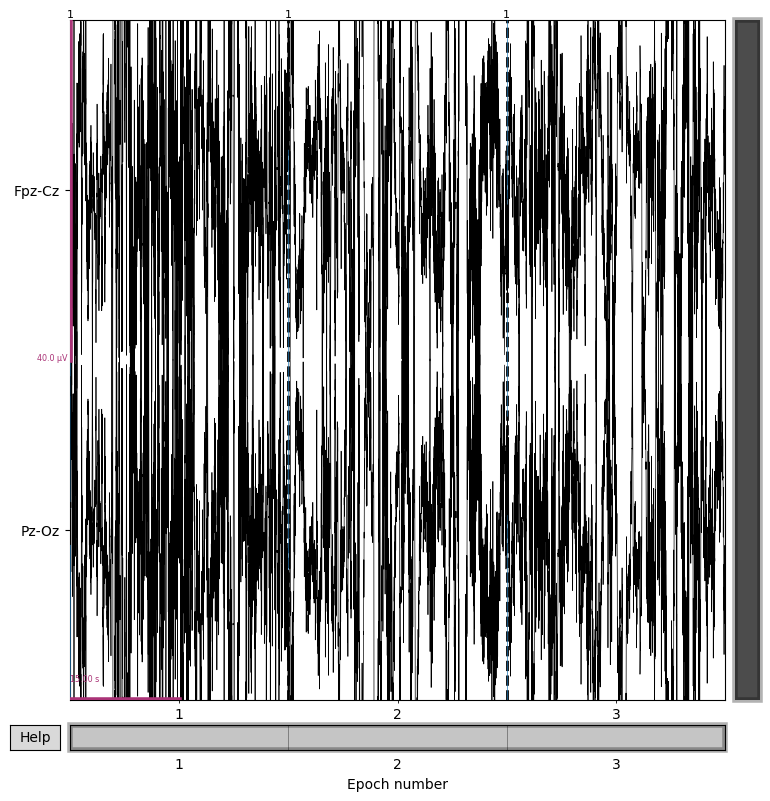

In [254]:
fig = epoch_EEG[1][1:4].plot(events=events_EEG[1])

In [255]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5 * n_channels]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

tentando com o random forest Classifier

In [258]:
pipe1 = make_pipeline(
    FunctionTransformer(eeg_power_band, validate=False),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

In [ ]:
epochs_train.events[:, 2]

Separar treino e teste

* Para EEG *

In [197]:
events_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 5,
    "Sleep stage R": 6}

In [211]:



fig, (ax1, ax2) = plt.subplots(ncols=2)

stages = sorted(events_id.keys())
for ax, title, epochs in zip([ax1, ax2], subjects, epoch_signals):
    for stage, color in zip(stages, stage_colors):
        spectrum = epochs[stage].compute_psd(fmin=0.1, fmax=20.0)
        spectrum.plot(
            ci=None,
            color=color,
            axes=ax,
            show=False,
            average=True,
            amplitude=False,
            spatial_colors=False,
            picks="data",
            exclude="bads",
        )
    ax.set(title=title, xlabel="Frequency (Hz)")
ax1.set(ylabel="µV²/Hz (dB)")
ax2.legend(ax2.lines[2::3], stages)


## não estou a conseguir fazer a cena individual

Using data from preloaded Raw for 58 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
Using data from preloaded Raw for 250 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
Using data from preloaded Raw for 101 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
Using data from preloaded Raw for 119 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
Using data from preloaded Raw for 125 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectr

Using data from preloaded Raw for 1103 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


/var/folders/l_/hg8v1x2n6sn481rmk8n90ftw0000gn/T/ipykernel_62277/1708352108.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epoch_signals[1].compute_psd(fmax=30).plot(picks="eeg", exclude="bads", amplitude=False)
/Users/Bia/Library/Python/3.9/lib/python/site-packages/mne/viz/utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


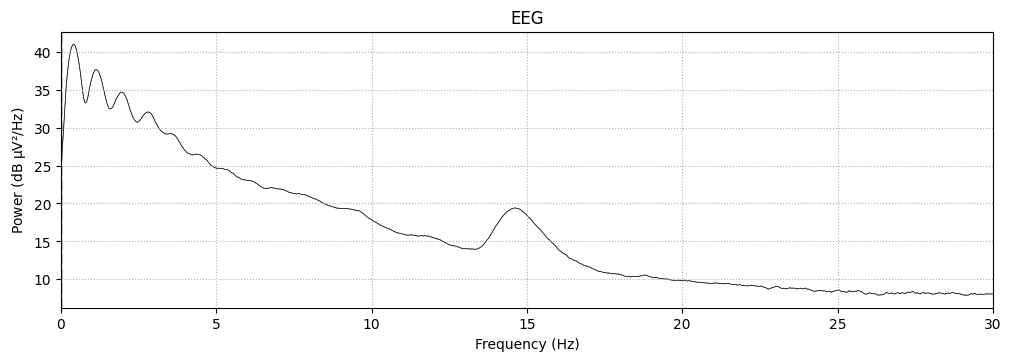

In [215]:
epoch_signals[1].compute_psd(fmax=30).plot(picks="eeg", exclude="bads", amplitude=False)


Using data from preloaded Raw for 20 events and 3000 original time points ...


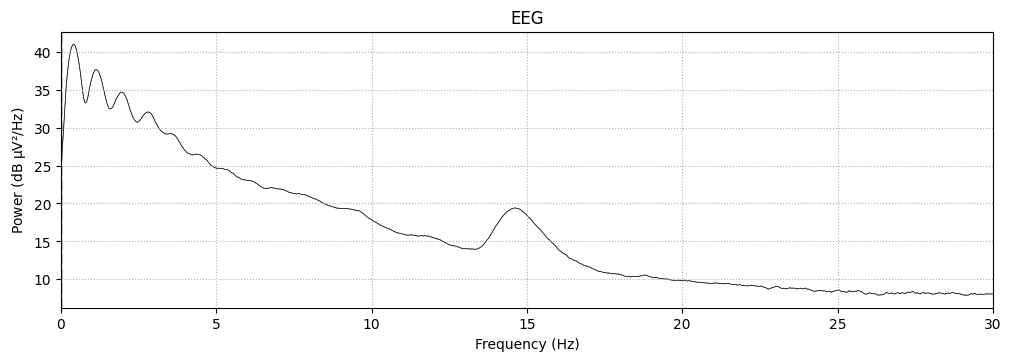

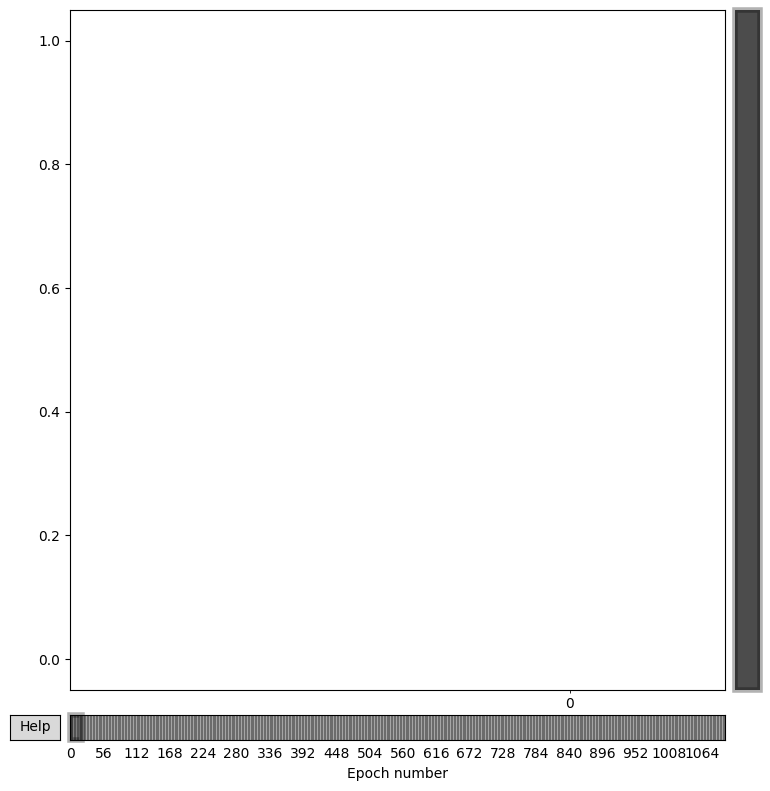

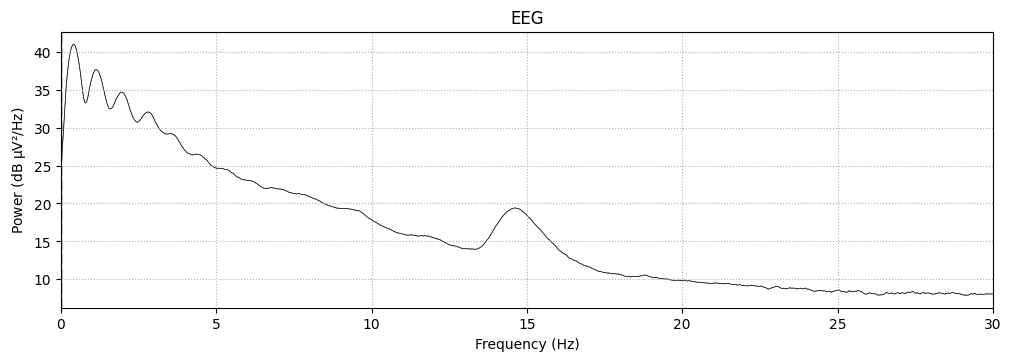

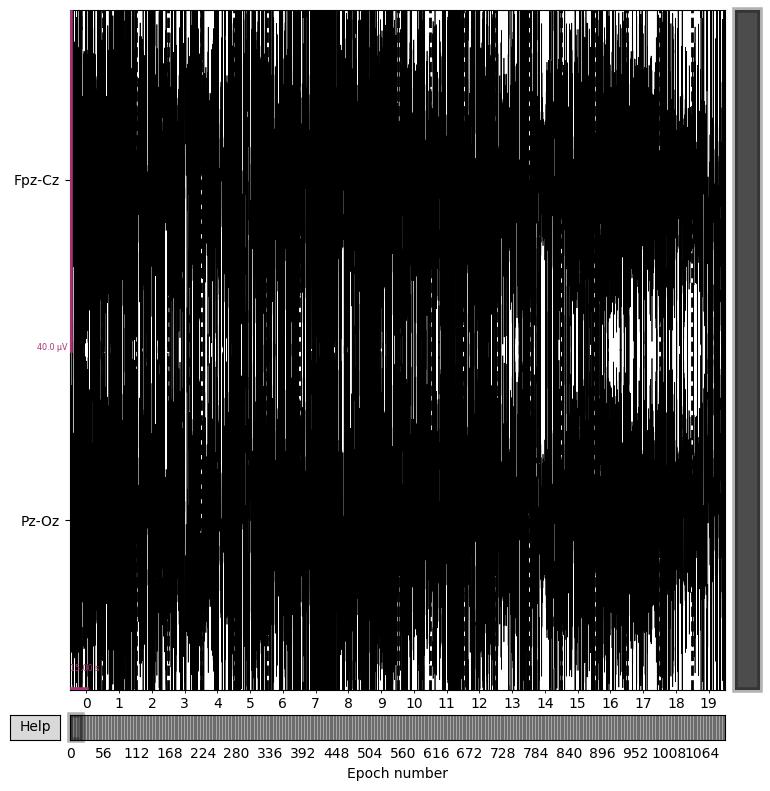

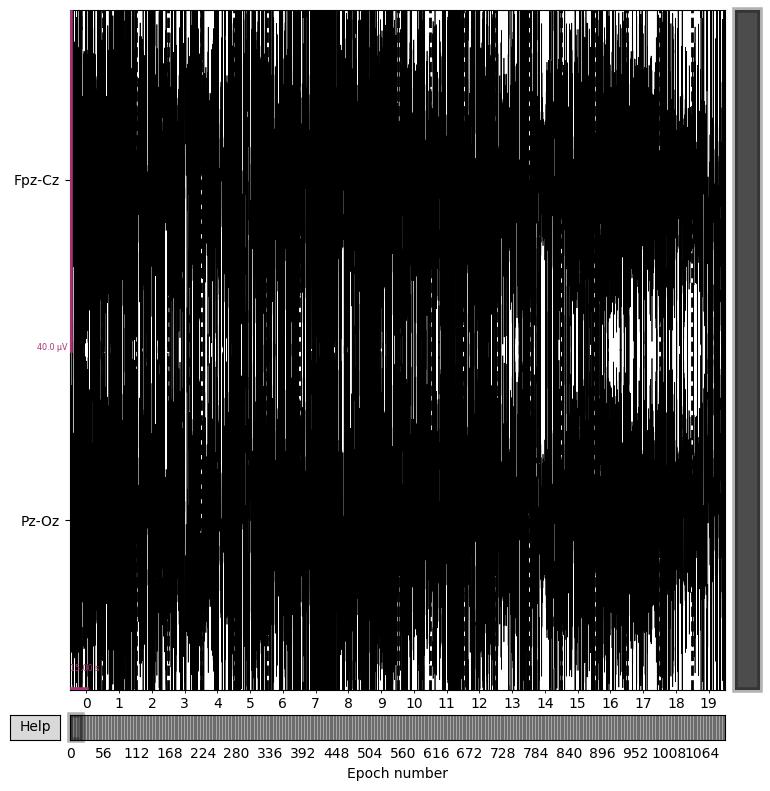

In [216]:
epoch_signals[1].plot( n_channels=2)

In [146]:
x_train = signal_seg[0:4]; y_train = annot[0:4]
x_test =  signal_seg[4:6]; y_train = annot[4:6]

In [ ]:
pipe = make_pipeline(
    FunctionTransformer(eeg_power_band, validate=False),
    RandomForestClassifier(n_estimators=100, random_state=42),
)